# Set-up

## Imports

In [120]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 200
from matplotlib.cm import Blues
import seaborn as sns
sns.set_theme()
colors = sns.color_palette("deep")
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

# statsmodels
from statsmodels.tsa.stattools import adfuller

## Parameters

In [121]:
scope = 'BID'
model = 'RF'
extension = '.pkl'
cal = '' # _CALIBRATED

input_path = f'../data/3_output/ML_dataset_{scope}.pkl'
predictions_path = f'{scope}/model_predictions/{model}_predicted_probs_monthly_recal_rolling_12m{cal}{extension}'

start_month = 201901
end_month = 202212

subsample_size = None

target = 'Result'

## Functions

In [97]:
def AUCPR(groupby):
    return average_precision_score(groupby[target], groupby['y_probs'])

def Precision(groupby):
    return precision_score(groupby[target], (groupby['y_probs'] >= 0.5))

def Recall(groupby):
    return recall_score(groupby[target], (groupby['y_probs'] >= 0.5))

def F1(groupby):
    return f1_score(groupby[target], (groupby['y_probs'] >= 0.5))

In [98]:
def get_score_per_group(df, group, score=AUCPR, plot=True, plot_kind='bar', plot_trend=False, hide_xlab=True, plot_baseline=False, ylab=None, **kwargs):
    score_df = df.groupby(group, as_index=False).apply(score).rename({None: score.__name__}, axis=1)
    score_df.sort_values(group, inplace=True)
    score_df[group[0]] = score_df[group[0]].astype(str)
    if plot:
        fig, ax = plt.subplots()
        if len(group) > 1:
            score_df.pivot(index=group[0], columns=group[1], values=score.__name__).plot(kind='bar', ax=ax, **kwargs)
        else:
            score_df.set_index(group[0]).plot(kind=plot_kind, legend=False, ax=ax, **kwargs)
        if plot_trend:
            mean_score = score_df[score.__name__].mean()
            ax.axhline(y=mean_score, linestyle='--', color='red', linewidth=1)
            # Add annotation for correlation coefficient
            ax.annotate('$\mu = {:.2f}$'.format(mean_score), xy=(0.78, 0.81), xycoords='axes fraction',  
            xytext=(20, 20), textcoords='offset points',  fontsize=14, color='red')
        if plot_baseline:
            ax1 = ax.twinx()
            rate_df = df.groupby(group, as_index=False)["Result"].mean()
            rate_df[group[0]] = rate_df[group[0]].astype(str)
            ax1.plot(rate_df[group[0]], rate_df.Result, color='black', linewidth=1, markersize=3, label='Prior probability')
            ax1.set_ylabel('Prior probability')
            ax1.set_ylim((0, 0.06))
            ax.grid(False)
            ax1.grid(False)
        if hide_xlab:
            plt.xlabel(None)
        plt.xticks(rotation=0)
        if ylab:
            plt.ylabel(ylab)
        else:
            plt.ylabel(score.__name__)
        # plt.ylim((0,1))
        ax.set_ylim((0, 1))
        # plt.title('{} bids APS per {}'.format(scope, group[0]))
        # plt.tight_layout()
        # plt.savefig('../plots/{}/precision_recall/{}_{}_{}_{}.png'.format(scope, model, score.__name__, '_'.join(group), scope.lower()), bbox_inches='tight')
        plt.show()

    return score_df

In [99]:
def get_acc_rate_per_group(df, group, plot=True, **kwargs):
    rate_df = df.groupby(group, as_index=False)["Result"].mean()
    rate_df[group[0]] = rate_df[group[0]].astype(str)
    if plot:
        if len(group) > 1:
            rate_df.pivot(index=group[0], columns=group[1], values="Result").plot(kind='bar', **kwargs)
        else:
            rate_df.set_index(group[0]).plot(kind='bar', legend=False, **kwargs)
        plt.xlabel(group[0])
        plt.xticks(rotation=0)
        plt.ylabel('Acceptance rate')
        plt.title('{} bids acceptance rate per {}'.format(scope, group[0]))
        plt.tight_layout()
        plt.savefig('../plots/{}/{}_acc_{}_{}.png'.format(scope, model, '_'.join(group), scope.lower()))
        plt.show()

    return rate_df

In [100]:
def calibrate_proba_monthly_recal(df):
    """
    For each observation of the dataset, if M is the corresponding month, outputs the calibrated predicted probability of the model from the uncalibrated one, 
    using an isotonic regression trained on the M-12 to M-1 period.
    We hence fit a number of isotonic regressions equal to the number of months in the dataset.
    This allows to calibrate the probability output of the model in a "live" setting, where each month, the probabilities are calibrated with the new data.
    """
    observation_month = df.index.str[:6].astype(int)
    months = sorted(observation_month.unique())
    test_months = [month for month in  months if month >= start_month and month <= end_month]
    y_probs_cal_list =  []

    for test_month in tqdm(test_months):
        # For every month M, we take the training period as M-12 to M-1
        idx = months.index(test_month)
        train_months = months[idx-12:idx]
        select_train = observation_month.isin(train_months)
        x_train = df.loc[select_train, 'y_probs']
        y_train = df.loc[select_train, 'Result']
        # And the test period as month M
        x_test = df.loc[observation_month == test_month, 'y_probs']

        ir = IsotonicRegression(y_min=0, y_max=1).fit(x_train, y_train)
        y_probs_cal = ir.predict(x_test)
        # print("Test month is: ", test_month)
        # print("Train months are: ", train_months)
        # print("\n")

        y_probs_cal_list.append(y_probs_cal)
    
    return pd.Series(np.concatenate(y_probs_cal_list, axis=0), index=df[observation_month.isin(test_months)].index)

# Main

## Load dataset & model predictions

In [122]:
# Load dataset
input_df = pd.read_pickle(input_path)
df = input_df.copy()
# Select only observations for which we generated a prediction
df['yearmonth'] = df.index.str[:6].astype(int)
df['month'] = df.index.str[4:6].astype(int)
df['Month'] = pd.PeriodIndex(year=df['year'], month=df['month'], freq='M')
# df = df[(df.yearmonth >= start_month) & (df.yearmonth <= end_month)]
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,yearmonth,month,Month
2018010118UP_ALTOADDA_1_BID,18,20180101,2018,UP_ALTOADDA_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.349,False,201801,1,2018-01
2018010119UP_ALTOADDA_1_BID,19,20180101,2018,UP_ALTOADDA_1,BID,1.249924,0.598779,-1.772487,-0.866850,0.891173,...,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.329,False,201801,1,2018-01
2018010120UP_ALTOADDA_1_BID,20,20180101,2018,UP_ALTOADDA_1,BID,0.243493,0.768175,-1.758348,-0.872364,-0.334594,...,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.324,False,201801,1,2018-01
2018010117UP_ARSIE_1_BID,17,20180101,2018,UP_ARSIE_1,BID,3.456008,0.661794,-2.372137,-0.624680,3.037220,...,Belluno,Hydro Run-of-river and poundage,0.627,0.627,0.00,-1.000,False,201801,1,2018-01
2018010118UP_ARSIE_1_BID,18,20180101,2018,UP_ARSIE_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,Belluno,Hydro Run-of-river and poundage,1.000,1.000,0.00,-1.000,False,201801,1,2018-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_BID,17,20221231,2022,UP_VOGHERA_1,BID,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,Pavia,Fossil Gas,0.540,0.540,135.00,-0.350,False,202212,12,2022-12
2022123118UP_VOGHERA_1_BID,18,20221231,2022,UP_VOGHERA_1,BID,0.055686,-2.259989,-1.329127,0.607693,-2.561474,...,Pavia,Fossil Gas,1.000,1.000,136.00,-0.420,True,202212,12,2022-12
2022123119UP_VOGHERA_1_BID,19,20221231,2022,UP_VOGHERA_1,BID,-0.051126,-2.357014,-1.293692,0.548271,-2.484197,...,Pavia,Fossil Gas,1.000,1.000,138.00,-0.414,True,202212,12,2022-12
2022123120UP_VOGHERA_1_BID,20,20221231,2022,UP_VOGHERA_1,BID,-0.029177,-2.330178,-1.385200,0.630366,-2.484197,...,Pavia,Fossil Gas,1.000,1.000,141.00,-0.405,True,202212,12,2022-12


In [123]:
# Load model predictions
if cal == '_CALIBRATED':
    probs = 'y_probs_cal'
else:
    probs = 'y_probs'
if predictions_path.endswith('.csv'):
    y_probs = pd.read_csv(predictions_path, index_col=0)[probs]
else:
    y_probs = pd.read_pickle(predictions_path)
y_probs
# Below some obs could be dropped as NA as they were not in the prediction process
df['y_probs'] = y_probs
# We drop them
print(len(df))
# df.dropna(subset=['y_probs'], inplace=True)
print(len(df))

2177292
2177292


## Calibration curves

In [125]:
df['y_probs_cal'] = calibrate_proba_monthly_recal(df)

  0%|          | 0/36 [00:00<?, ?it/s]

Text(0, 0.5, 'Relative Frequency')

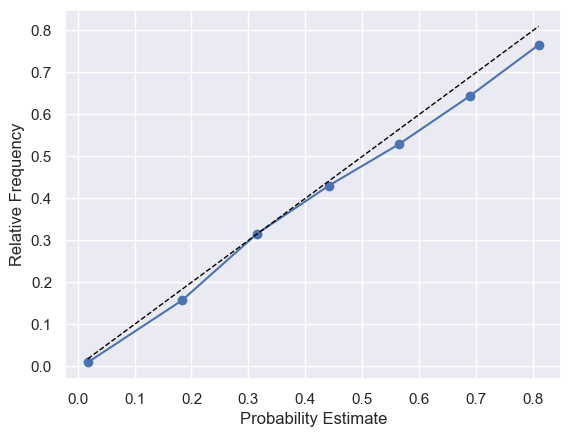

In [133]:
n_bins = 8

prob_true, prob_pred = calibration_curve(df.Result, df.y_probs, n_bins=n_bins)
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest with Recalibration', color=colors[0])

# prob_true_cal, prob_pred_cal = calibration_curve(df[df.year > 2019].Result, df[df.year > 2019].y_probs_cal, n_bins=n_bins)
# plt.plot(prob_pred_cal, prob_true_cal, label='Calibrated', marker='^', color=colors[1])

plt.plot(prob_pred, prob_pred, color='black', linestyle='dashed', label='Perfectly calibrated', linewidth=1)

plt.xlabel('Probability Estimate')
plt.ylabel('Relative Frequency')
# plt.legend()

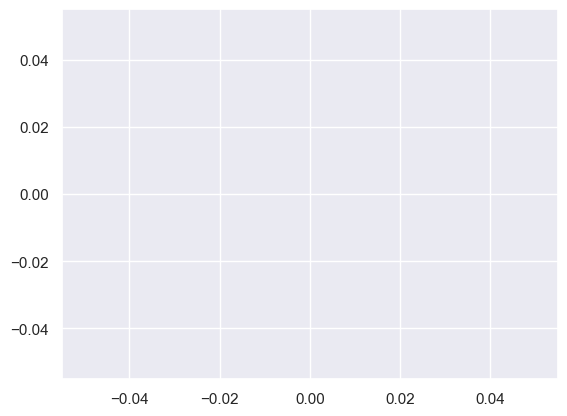

In [132]:
prob_true_cal, prob_pred_cal = calibration_curve(df.Result, df.y_probs, strategy='quantile', n_bins=10)
plt.plot(prob_pred_cal, prob_true_cal, label='Calibrated', marker='^', color=colors[1])

In [87]:
df[df.year > 2019].Result

202001011UP_ACTV_1_OFF        False
202001012UP_ACTV_1_OFF        False
202001013UP_ACTV_1_OFF        False
202001014UP_ACTV_1_OFF        False
202001015UP_ACTV_1_OFF        False
                              ...  
2022123117UP_VOGHERA_1_OFF    False
2022123121UP_VOGHERA_1_OFF    False
2022123122UP_VOGHERA_1_OFF    False
2022123123UP_VOGHERA_1_OFF    False
2022123124UP_VOGHERA_1_OFF    False
Name: Result, Length: 1988531, dtype: bool

In [79]:
len(df[(df.y_probs >= 0.85) & (df.y_probs < 0.9)])

57

In [49]:
len(df) / n_bins

27644.99

In [26]:
df.loc[(df.y_probs >= 0.9) & (df.y_probs < 1), "Result"].mean()

0.7142857142857143

In [25]:
df.loc[(df.y_probs >= 0.9) & (df.y_probs < 1), "y_probs"].mean()

0.905

In [11]:
df.y_probs_cal.to_pickle(f'{scope}/model_predictions/{model}_predicted_probs_monthly_recal_rolling_12m_CALIBRATED{extension}')

## Performance analysis

### Overall performance per year

In [134]:
aps_df = get_score_per_group(df, group=['year'], figsize=(4,5))

ValueError: Input contains NaN.

In [53]:
aps_df

,year,AUCPR
0,2019,0.325270
1,2020,0.407729
2,2021,0.388073
3,2022,0.389153


### Overall performance per hour

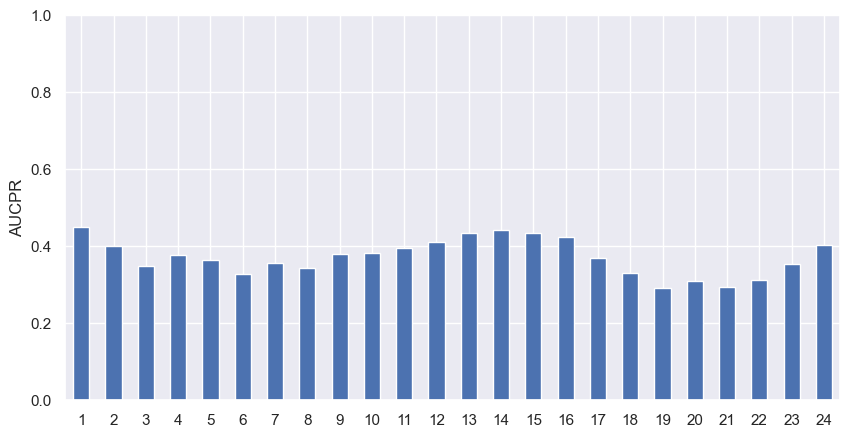

,hour,AUCPR
0,1,0.447970
1,2,0.398410
2,3,0.347846
3,4,0.376923
4,5,0.363770
5,6,0.326264
6,7,0.355111
7,8,0.342708
8,9,0.377581
9,10,0.380210


In [54]:
aps_df = get_score_per_group(df, group=['hour'], figsize=(10,5))
aps_df

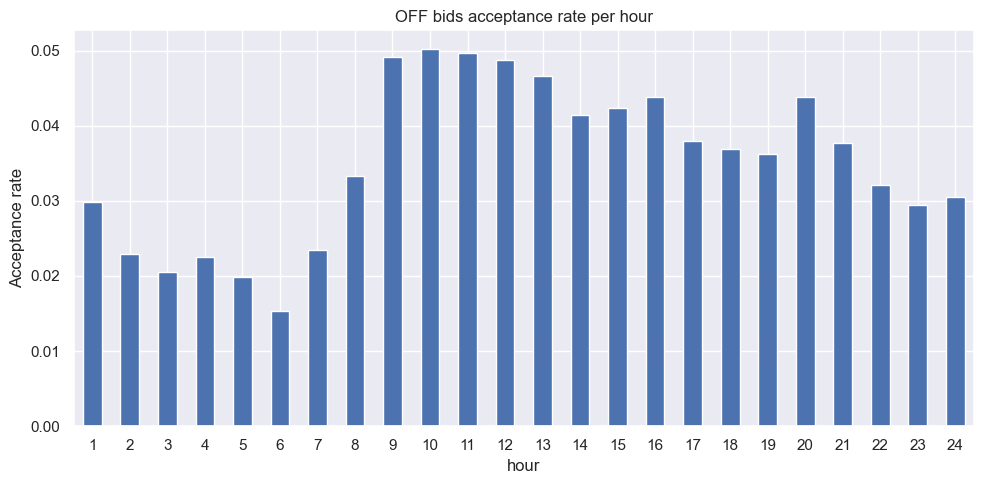

,hour,Result
0,1,0.029885
1,2,0.022915
2,3,0.020489
3,4,0.022537
4,5,0.019896
5,6,0.015401
6,7,0.023426
7,8,0.033341
8,9,0.049176
9,10,0.050177


In [55]:
acc_df = get_acc_rate_per_group(df, ["hour"], figsize=(10,5))
acc_df

So it seems that it is the acceptance rate is not really driving the variability in the performance of the model

### Overall performance per month

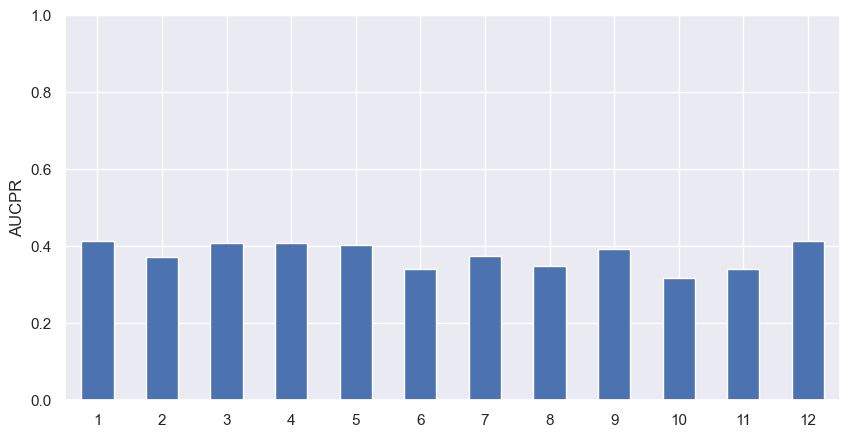

,month,AUCPR
0,1,0.412551
1,2,0.370314
2,3,0.407609
3,4,0.407720
4,5,0.401288
5,6,0.340147
6,7,0.372658
7,8,0.348307
8,9,0.392135
9,10,0.316171


In [56]:
aps_df = get_score_per_group(df, group=['month'], figsize=(10,5))
aps_df

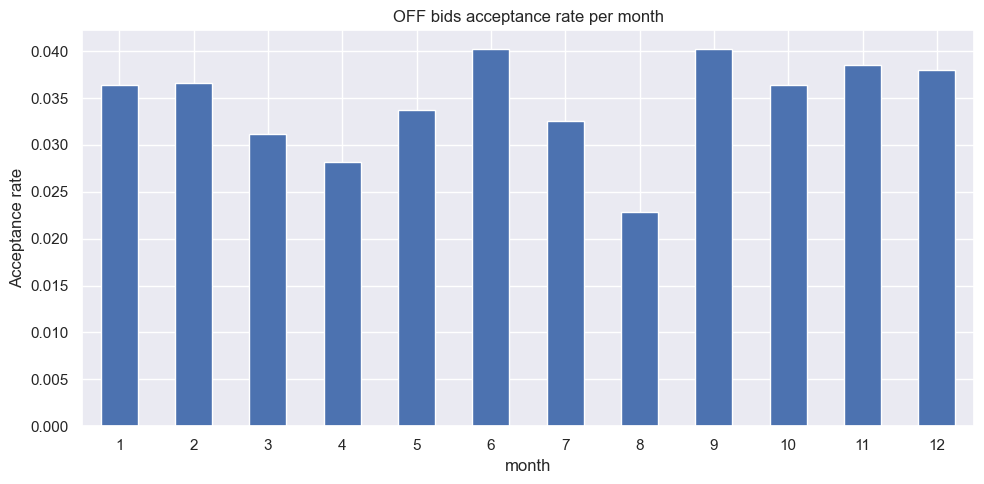

,month,Result
0,1,0.036406
1,2,0.036605
2,3,0.031193
3,4,0.028153
4,5,0.033721
5,6,0.040205
6,7,0.032513
7,8,0.022800
8,9,0.040181
9,10,0.036401


In [57]:
acc_df = get_acc_rate_per_group(df, ["month"], figsize=(10,5))
acc_df

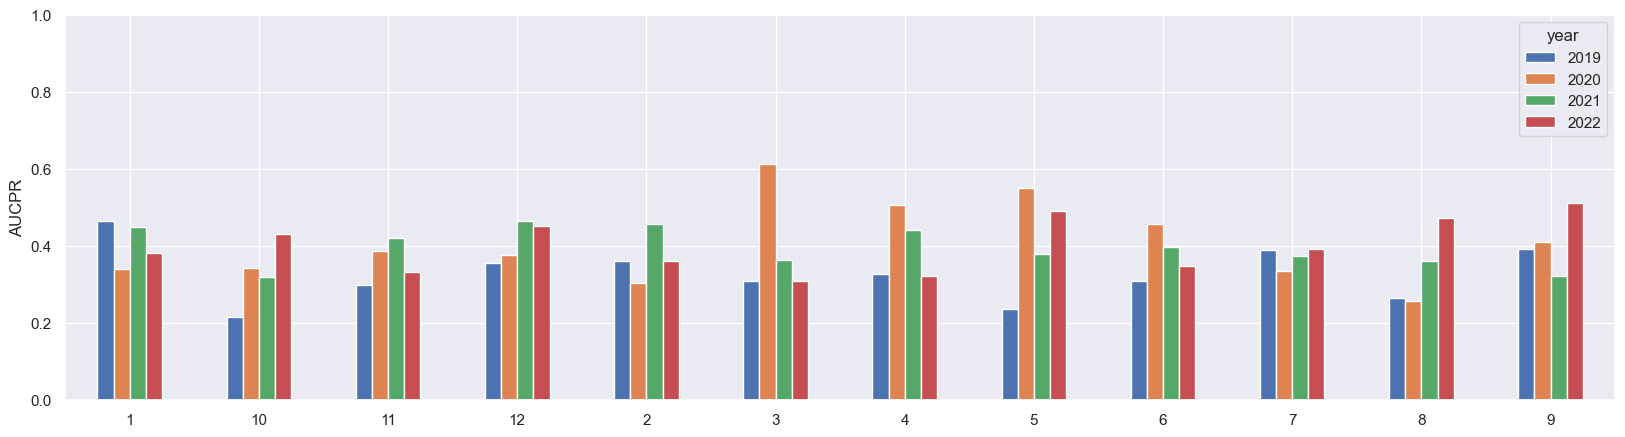

In [58]:
aps_df = get_score_per_group(df, group=['month', 'year'], figsize=(20,5))

### Overall performance per technology

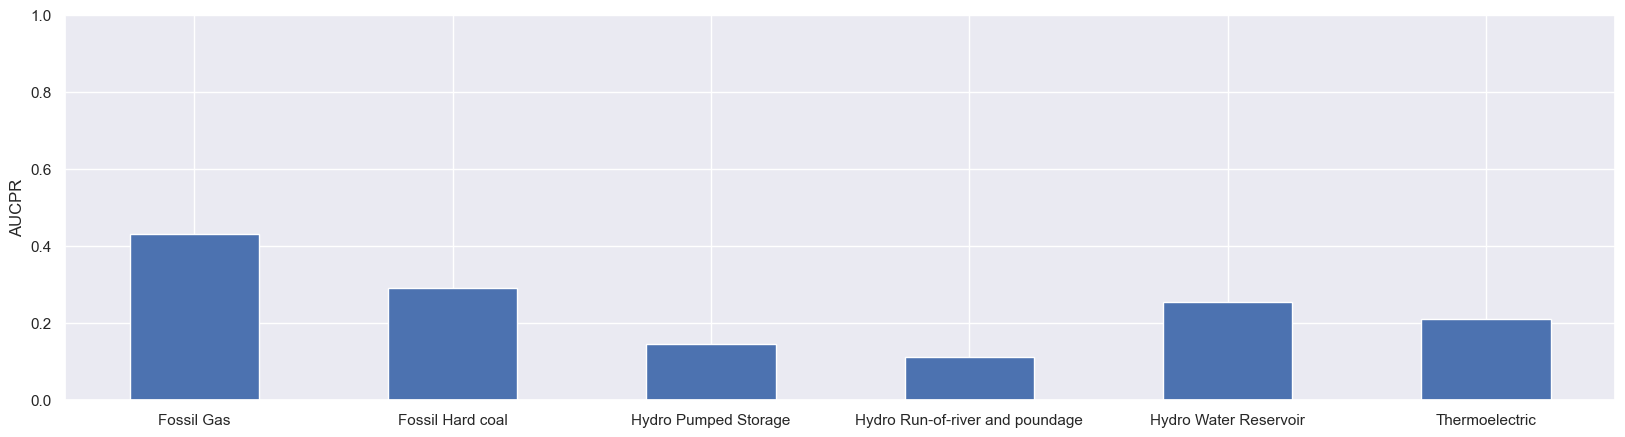

,Tech,AUCPR
0,Fossil Gas,0.431249
1,Fossil Hard coal,0.291662
2,Hydro Pumped Storage,0.146038
3,Hydro Run-of-river and poundage,0.111623
4,Hydro Water Reservoir,0.253970
5,Thermoelectric,0.210002


In [59]:
aps_df = get_score_per_group(df, group=['Tech'], figsize=(20,5))
aps_df

In [60]:
df.Tech.value_counts()

Tech
Fossil Gas                         817752
Hydro Water Reservoir              787059
Hydro Pumped Storage               503674
Hydro Run-of-river and poundage    329261
Thermoelectric                     171779
Fossil Hard coal                   154974
Name: count, dtype: int64

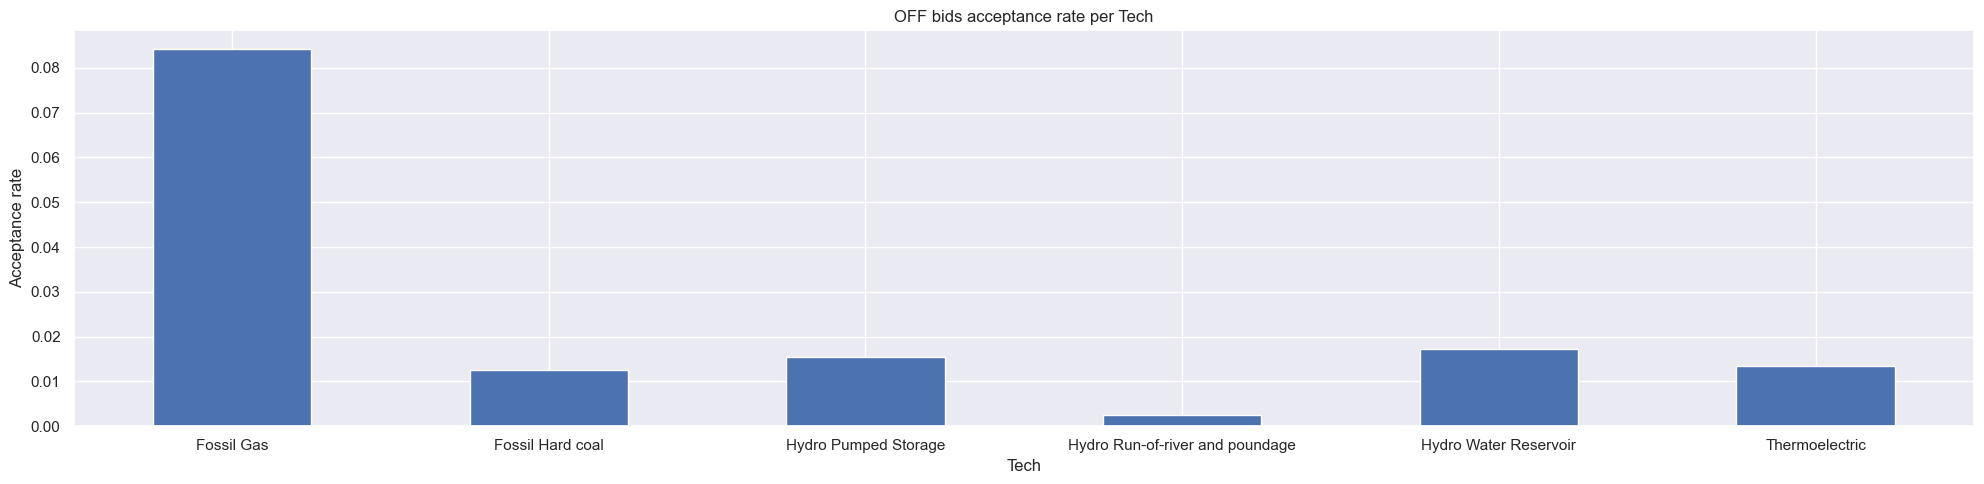

In [61]:
acc_df = get_acc_rate_per_group(df, ["Tech"], figsize=(20,5))

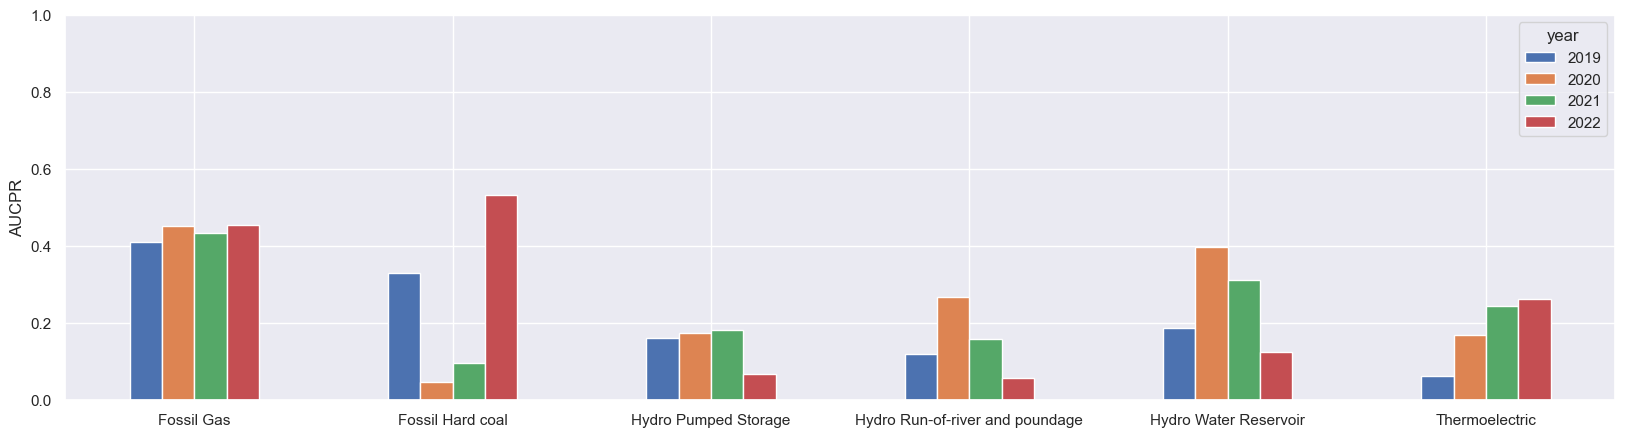

In [62]:
aps_df = get_score_per_group(df, group=['Tech', 'year'], figsize=(20,5))

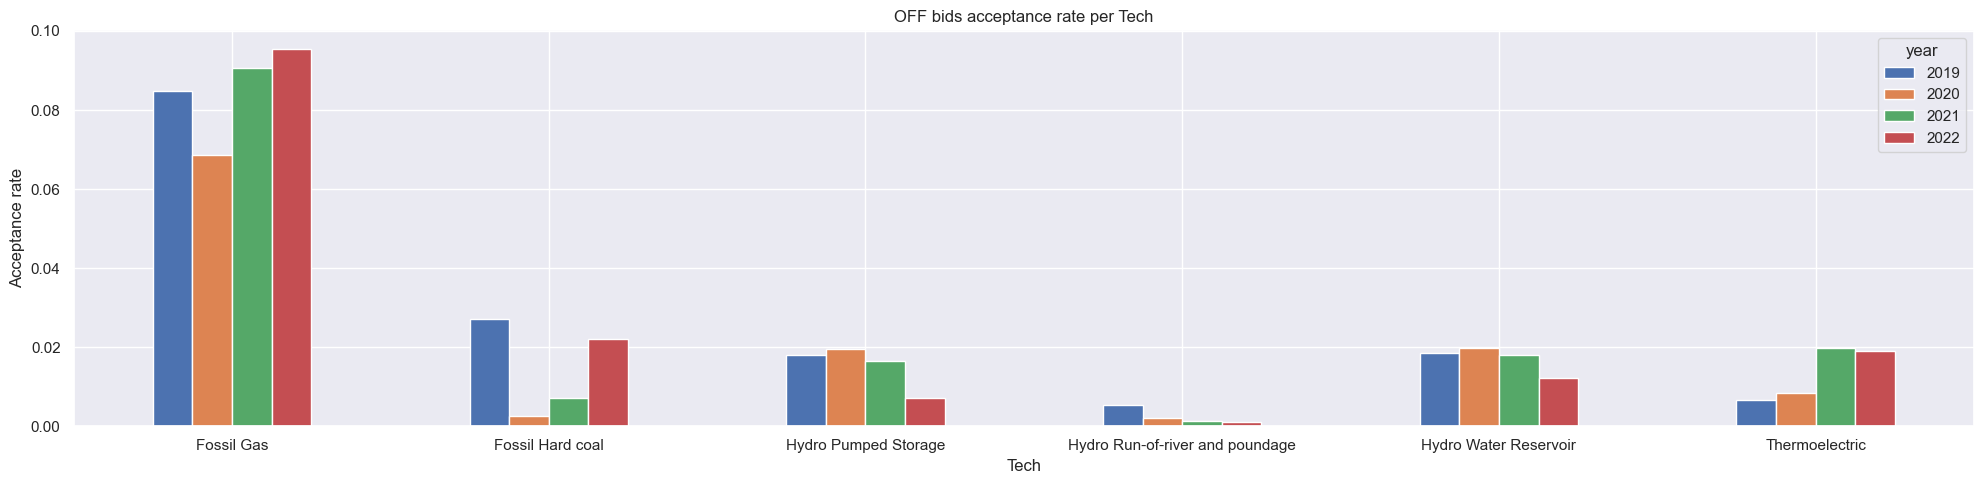

In [63]:
acc_df = get_acc_rate_per_group(df, ["Tech", "year"], figsize=(20,5))

### Time series of monthly performance

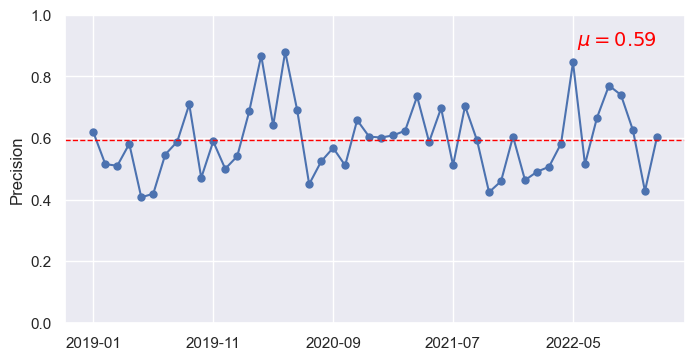

In [68]:
precision_df = get_score_per_group(df, score=Precision, group=['Month'], plot_kind='line', figsize=(8,4), marker='o', markersize=5, plot_trend=True,
                                 #   plot_baseline=True
                                   )

In [65]:
adfuller(precision_df.Precision)

(-5.280789494559825,
 6.00031901664753e-06,
 0,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 -51.31910915321811)

array([[<Axes: title={'center': 'Precision'}>]], dtype=object)

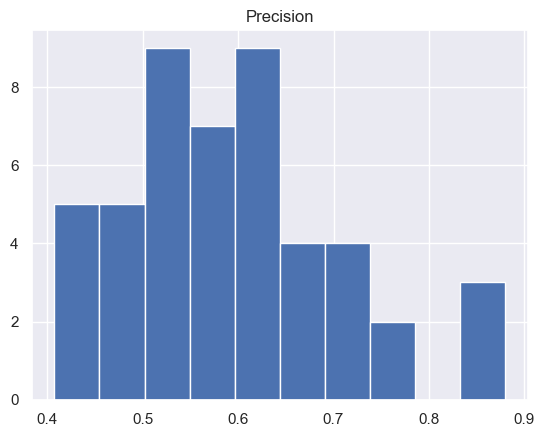

In [66]:
precision_df.hist()

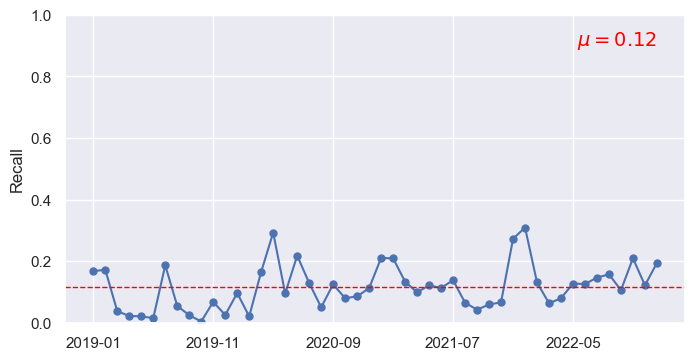

In [73]:
recall_df = get_score_per_group(df, score=Recall, group=['Month'], plot_kind='line', plot_trend=True, figsize=(8,4), marker='o', markersize=5,
                                # plot_baseline=True
                                )

In [70]:
adfuller(recall_df.Recall)

(-4.622502800595738,
 0.00011737984647366075,
 0,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 -91.17875174858739)

array([[<Axes: title={'center': 'Recall'}>]], dtype=object)

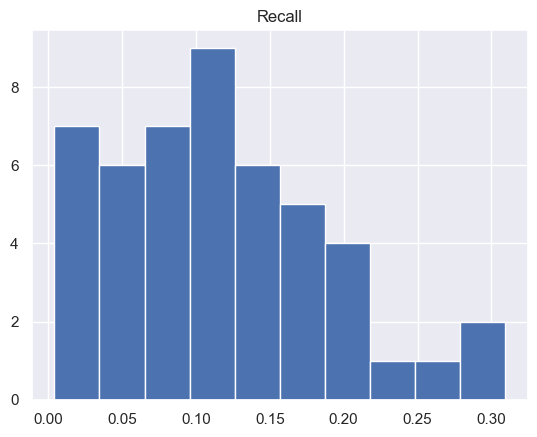

In [71]:
recall_df.hist()

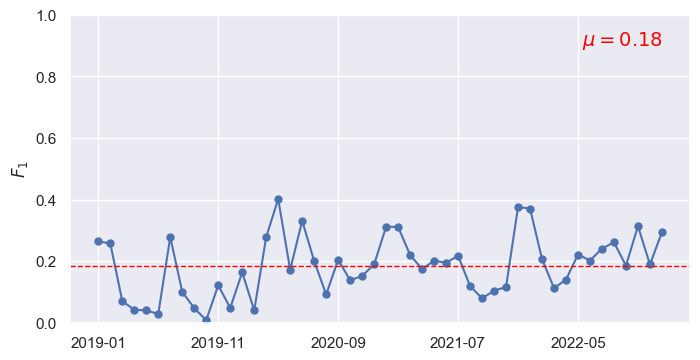

In [74]:
f1_df = get_score_per_group(df, score=F1, group=['Month'], plot_kind='line', figsize=(8,4), plot_trend=True, ylab='$F_1$', marker='o', markersize=5,
                            # plot_baseline=True
                            )

In [75]:
adfuller(f1_df.F1)

(-4.5011343146927825,
 0.00019571396214258335,
 0,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 -72.5006990435777)

array([[<Axes: title={'center': 'F1'}>]], dtype=object)

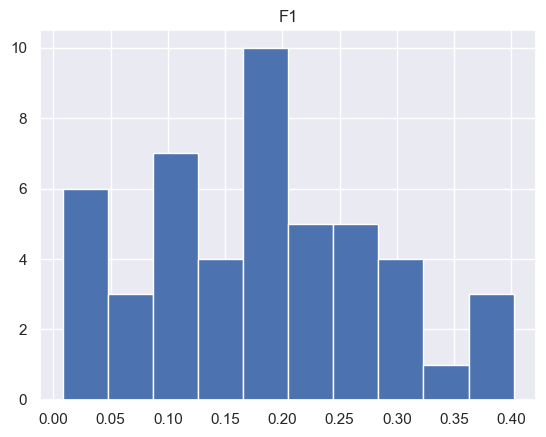

In [76]:
f1_df.hist()

In [ ]:
input_df.to_csv(input_path.replace('.pkl', '.csv'))

<HR>

# TESTS

In [22]:
df['y_probs'].max()

0.92

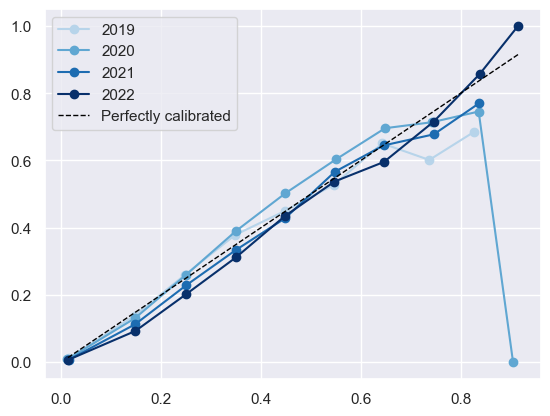

In [80]:
n_bins = 10
cmap = [Blues(value) for value in np.linspace(0.3, 1, 4)]
for k, year in enumerate(df.year.unique()):
    prob_true, prob_pred = calibration_curve(df[df.year == year].Result, df[df.year == year].y_probs, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o', label=year, color=cmap[k])
plt.plot(prob_pred, prob_pred, color='black', linestyle='dashed', label='Perfectly calibrated', linewidth=1)
plt.legend()

In [1]:
n_bins = 10
year = 2021

prob_true, prob_pred = calibration_curve(df[df.year == year].Result, df[df.year == year].y_probs, n_bins=n_bins)
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated', color=colors[0])

# prob_true, prob_pred = calibration_curve(df[df.year == year].Result, df[df.year == year].y_probs_cal, n_bins=n_bins)
# plt.plot(prob_pred, prob_true, label='Calibrated', marker='^', color=colors[1])

plt.plot(prob_pred, prob_pred, color='black', linestyle='dashed', label='Perfectly calibrated', linewidth=1)

plt.xlabel('Average predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()

NameError: name 'calibration_curve' is not defined